In [401]:
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras import optimizers


import sys
from collections import Counter 
import pprint 
import math
import argparse 
import os
import collections
import json
import re
import numpy as np
import matplotlib.pyplot as plt 
import random
import time 
import pandas as pd
import itertools
import tensorflow as tf

seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.set_random_seed(seed_value)
from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=4, inter_op_parallelism_threads=4)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [402]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# funtions to handle labels
from utils.handle_labels import get_tag_counts_and_labels
from utils.handle_labels import drop_labels
from utils.handle_labels import group_labels
from utils.handle_labels import categories_count
from utils.handle_labels import get_imbalance
from utils.handle_labels import label_distribution
from utils.handle_labels import number_of_labels
#from utils.message_preprocess import message_processing
# plot untils funcion
from utils.plot_utils import pie_plot

(1922, 28)
<class 'list'>
['Testing', 'Bug fix']
Maintenance : 891
Feature Add : 330
Bug fix : 266
Documentation : 237
Clean up : 192
Refactoring : 111
Indentation : 48
Token Replace : 40
Source Control : 30
Cross : 24
Legal : 18
Debug : 10
Module Remove : 6
Rename : 5
Module Move : 5
Versioning : 4
Merge : 3
Initialization : 2
Module Add : 1
Internationalization : 1
Data : 1
1    1625
2     226
3      35
4       7
5       3
dtype: int64


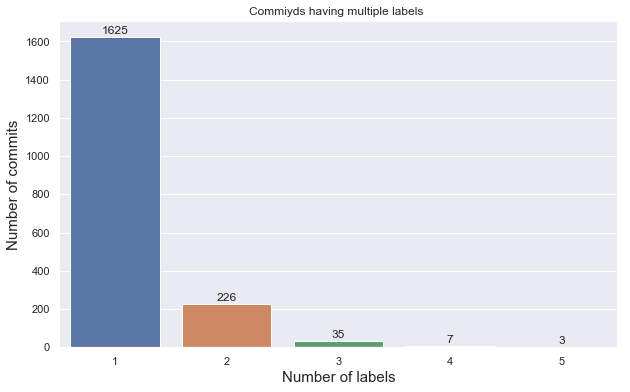

Adaptive : 237
Non_functional : 70
Corrective : 266
Implementation : 330
Other : 34
Perfective : 1093


In [403]:
df = pd.read_csv('data/commit_data_new.csv')
print(df.shape)

# convert string to list
from ast import literal_eval

df['categories'] = df['categories'].apply(lambda x: literal_eval(x))
print(type(df['categories'].values[0]))
print(df['categories'].values[0])
df = df.drop(['Unnamed: 0'], axis = 1)
df.head()

#tags_counts,target_columns = get_tag_counts_and_labels(df)
#print(target_columns)

# drop testing and build
new_df = drop_labels(df, ['Testing', 'Build'])
_ , target_col = get_tag_counts_and_labels(new_df)
multi_count = number_of_labels(new_df, target_col)

def group_labels_new(df, labels_to_group, new_label):
    '''
    Group some of labels

    Args:
        df - dataframe
        labels_to_group -  List of labels you want to group
        new_label -  string - new label name of grouped labels

    Returns:
        new_df - dataframe after grouped
    '''
    new_df = df.copy()

    # generate new labels by group labels
    def create_new_label(row, labels):
        new_label = 0  # initialize new label
        for label in labels:
            if row[label] == 1:
                new_label = 1  # if one of labels in grouped labels is 1 the new label is 1
        return new_label

    new_df[new_label] = df.apply(lambda row: create_new_label(row, labels_to_group), axis=1)

    # generate list of new_categories

    return new_df

new_df = group_labels_new(new_df, ['Bug fix'], 'Corrective')
new_df = group_labels_new(new_df, ['Documentation'], 'Adaptive')
new_df = group_labels_new(new_df, ['Clean up', 'Maintenance','Refactoring'], 'Perfective')
new_df = group_labels_new(new_df, ['Feature Add'], 'Implementation')
new_df = group_labels_new(new_df, ['Legal', 'Module Remove','Rename','Token Replace','Merge'], 'Non_functional')
new_df = group_labels_new(new_df, ['Cross','Debug'], 'Other')

target_col = ['Corrective','Adaptive','Perfective','Implementation','Non_functional','Other']
multi_count = categories_count(new_df, target_col)

### Drop Non-functional and Other 

In [404]:
# Drop 'Non-functional' and 'Other'

new_df = new_df.drop(['Non_functional','Other'],axis = 1)

target_col = ['Corrective','Adaptive','Perfective','Implementation']
multi_count = categories_count(new_df, target_col)

Implementation : 330
Adaptive : 237
Corrective : 266
Perfective : 1093


### Drop Multi-Label Rows 

1    1616
2     136
0     132
3      10
4       2
dtype: int64


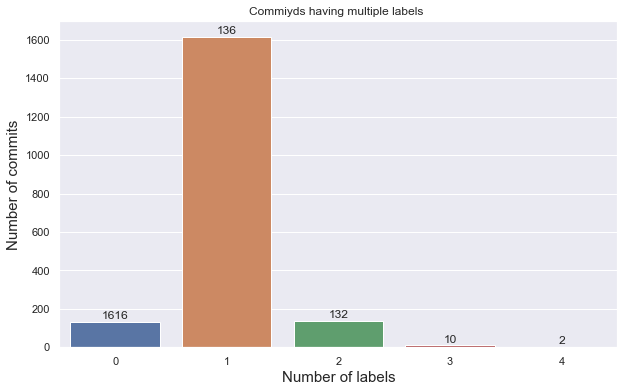

current number of samples: 1896
number of samples after drop:1616


In [405]:
# Drop rows with multiple labels
target_col = ['Corrective','Adaptive','Perfective','Implementation']
multi_count = number_of_labels(new_df, target_col)

print('current number of samples: %d'%new_df.shape[0])
new_df['label_sum'] = new_df[target_col].sum(axis=1)
new_df = new_df[new_df['label_sum']==1].reset_index(drop=True)
print('number of samples after drop:%d'%new_df.shape[0])
new_df = new_df.drop(['label_sum'], axis = 1)

### Drop Target Columns 

In [406]:
# Drop target col
# new_df = new_df[new_df['Corrective']!=1].reset_index(drop=True)
target_col = ['Corrective','Adaptive','Perfective','Implementation']

In [407]:
csha = new_df['Commit ID'].values
files = [c + '.json' for c in csha]
application_name = new_df['project name'].values
files_path = []
for project_name, c in zip(application_name,files):
    files_path.append(project_name + '_' + c)
print(files_path[0])

apache-avro_126e9769f45f978f42321c4fc465198982df482b.json


### Parse JSON Files 

In [408]:
def parse_json(filepath, files):
    """
    function used to parse json of each commit json file

    Args:
        filepath_list - list of filepaths

    Returns:
        files_json - list object contains parsed information

    """

    files_json = []
    commit_ids = []
    # each commits
    #files = os.listdir(filepath)
    for path in files:
        commit_id = path.split("_")[1].split(".")[0]
        try:
            if os.stat(filepath + path).st_size != 0 and path != 'desktop.ini':
                with open(filepath + path, encoding="utf8") as f:
                    data = json.load(f)
                    files_list = []
                    # each file in commits
                    for file in data['files']:
                        # parse only cluster file
                        for key in file.keys():
                            if re.match('^.*_cluster$', key):
                                actions_list = []
                                actions = file[key]['actions']
                                # each action in file
                                for action in actions:
                                    actions_list.append(action['root'])
                                files_list.append(actions_list)
                if len(files_list) != 0:
                    files_json.append(files_list)
                    commit_ids.append(commit_id)
        except FileNotFoundError as e: 
            continue 
    assert(len(commit_ids) == len(files_json))      
    # return
    return files_json, commit_ids

files = files_path
folder_path = 'C:\\Users\\ichel\\Desktop\\shared_ReFiles\\AllFiles_Research\\'
all_files, csha = parse_json(folder_path, files)

### Preprocess Roots 

In [409]:
def preprocess_roots(files_data):
    counting = {}
    for file_index, files in enumerate(files_data):
        for root_index, roots in enumerate(files):
            for action_index, actions in enumerate(roots):
                temp = actions.split(' at ')[0].strip()
                tempq = []
                if temp.startswith('INS'):
                    tempq.append('INS')
                    words = [temp.split('INS ')[1].split('to ')[0].strip()] + [
                        temp.split('INS ')[1].rsplit('to ')[-1].strip()
                    ]
                    for items in words:
                        items = items.split(':')[0].strip()
                        tempq.append(items)
                    if tempq[1] == 'TextElement' and tempq[-1] not in ['TagElement', 'TextElement']:
                        tempq[-1] = ''
                    temp = '_'.join(tempq)

                if temp.startswith('UPDATE'):
                    temp = 'UPDATE'
                if temp.startswith('MOVE'):
                    temp2 = temp.split('from ')[1].strip()
                    tempq.append('MOVE')
                    tempq.append(temp2.split(':')[0].strip())
                    temp = '_'.join(tempq)

                if temp.startswith('DEL'):
                    tempq.append('DEL')
                    tempq.append(temp.split('DEL ')[1].split(':')[0].strip())
                    temp = '_'.join(tempq)
                temp = temp.replace(' ', '_')
                counting[temp] = counting.get(temp, 0) + 1
                files_data[file_index][root_index][action_index] = temp
    dic = {}
    i = 0
    for k, v in counting.items():
        dic[k] = i
        i += 1
    return dic, files_data, counting

In [410]:
_, datas, _ = preprocess_roots(all_files)

### Convert actions in files to list of sentences 

In [411]:
def actions2sentence(datas):
    data_total = []
    for files in datas:
        data4file = []
        for roots in files:
            sentence = ' '.join(roots)
            data4file.append(sentence)
        data_total.append(data4file)
    return data_total


training_data = actions2sentence(datas)
print(training_data[14])

['UPDATE', 'UPDATE UPDATE', 'UPDATE', 'UPDATE']


## Data Preperation: 
Prepare data for embedding and training .

In [412]:
from utils.handle_labels import drop_labels
from utils.handle_labels import group_labels
from ast import literal_eval

In [413]:
def permutate_files_td(csha, training_data): 
    commits_dic = dict()
    for sha, training_file in zip(csha, training_data): 
        commits_dic[sha] = []
        if len(training_file) <= 5: 
            tmp_permutate = list(itertools.permutations(training_file))
            for permutated_file in tmp_permutate: 
                commits_dic[sha].append(list(permutated_file))
        else: 
            commits_dic[sha].append(training_file)
    return commits_dic

In [414]:
def expand_list(commits_labels_df):
    s= commits_labels_df.apply(lambda x: pd.Series(x['Files']),axis=1).stack().reset_index(level=1, drop=True)
    s.name = "Files"
    commits_labels_df = commits_labels_df.drop("Files", axis=1) 
    commits_labels_df = commits_labels_df.join(s)
    return commits_labels_df

In [415]:
# merge csha and training data to a dataframe
commits_df = pd.DataFrame(data = [csha, training_data]).T
commits_df.columns = ["Commit ID", "Files"]
print(new_df.shape)

# merge two dataframe and drop some of labels
commits_labels_df = pd.merge(commits_df, new_df, on='Commit ID')
print(commits_labels_df.shape)

(1616, 29)
(1403, 30)


### Concat Files 

In [416]:
# def concat_files_to_sentence(expanded_train_list): 
#     concat_data = ""
#     tmp_list = []
#     for items in expanded_train_list:
#         concat_data = " ".join(items)
#         tmp_list.append(concat_data)
#     return tmp_list
# concat_data = concat_files_to_sentence(commits_labels_df["Files"])

## Determine File Threshold 

Max files length: 261
Max roots length: 643


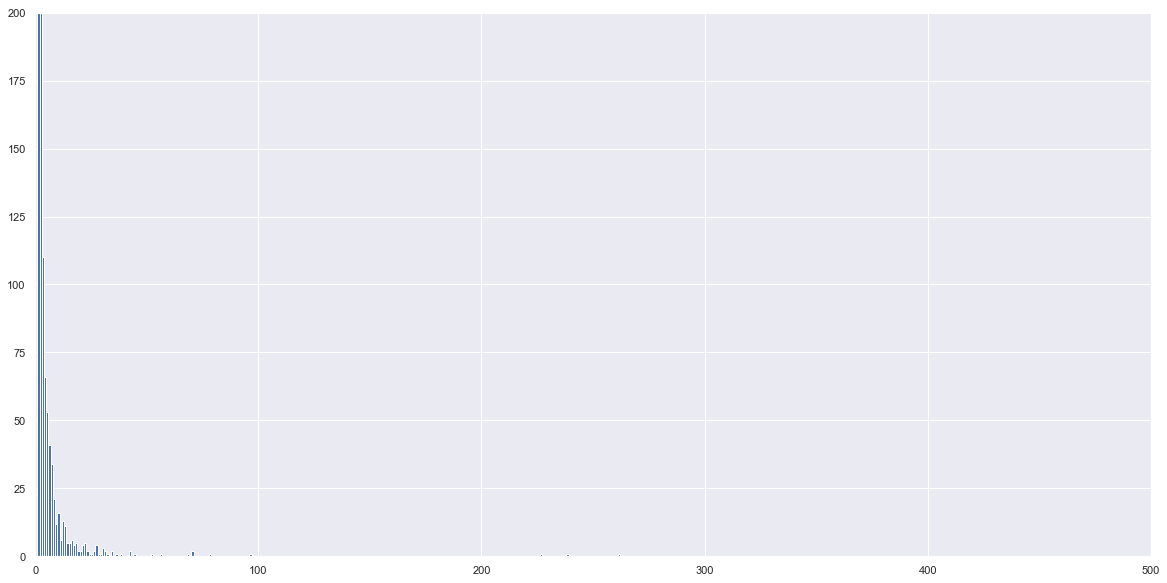

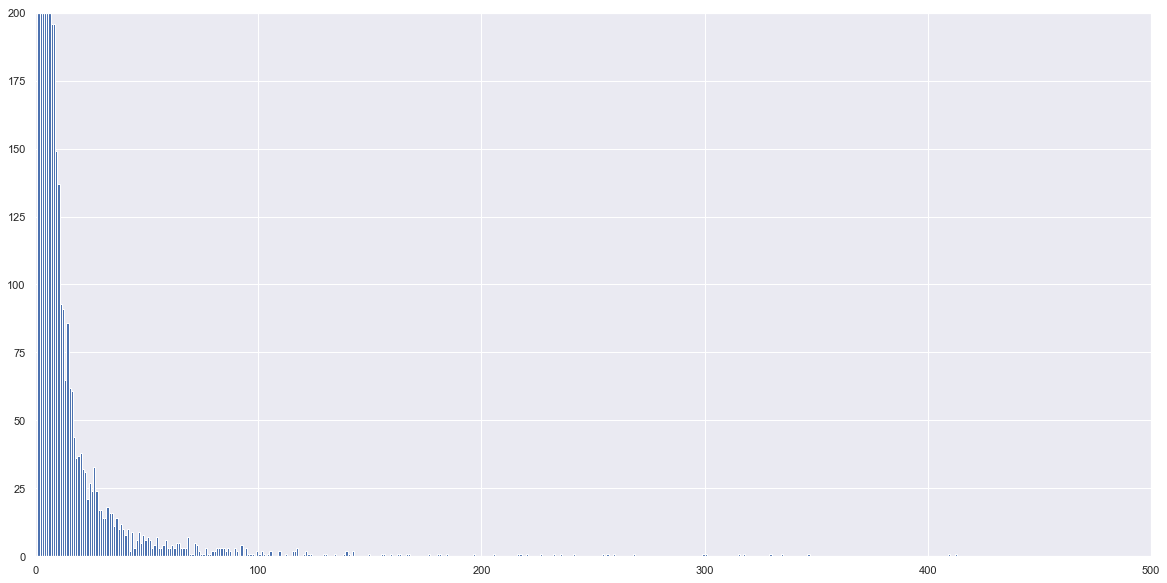

In [417]:
def get_seqlength(training_data):
    max_root_len = 0
    seqlength_list = []
    for item in training_data:
        seqlength_list.append(len(item.split()))
        if len(item.split()) >  max_root_len: 
            max_root_len = len(item.split())
    return max_root_len, seqlength_list

def plot_hist(seqlength_list): 
    plt.figure(figsize=(20,10))
    number_of_files = np.array(seqlength_list)
    bincount = np.bincount(seqlength_list)
    x = np.arange(1, len(bincount)+1)
    n, bins, patches = plt.hist(seqlength_list,x)
    plt.xlim((0, 500))
    plt.ylim((0, 200))

def get_number_of_roots_list(files):
    number_of_roots = []
    for file in files:
        number_of_roots.extend([len(roots.split()) for roots in file])
    return number_of_roots

# calculate number of files threshold
files = commits_labels_df["Files"]
number_of_files = [len(file) for file in files]

max_seqlength_files, files_sequence_list = max(number_of_files), number_of_files
plot_hist(files_sequence_list)
print('Max files length: %s'%max_seqlength_files)

# calculate number of roots threshold
number_of_roots = get_number_of_roots_list(files)
max_seqlength_roots, roots_sequence_list = max(number_of_roots), number_of_roots
plot_hist(roots_sequence_list)
print('Max roots length: %s'%max_seqlength_roots)

### Get Padding Threshold

In [418]:
# getting file threshold
threshold = 0.95
def get_file_threshold(number_of_files, threshold = 0.95):
    '''
    get padding threshold for files dimension
    
    Args:
        number_of_files - array of the number of files in each commits
        threshold - drop all commits with its the number of files beyond this threshold
    Returns:
        padding threshold - number
    '''
    
    total_files = len(number_of_files)
    number_of_files = np.array(number_of_files)
    bincount = np.bincount(number_of_files)

    sum_file = 0
    for index, item in enumerate(bincount):
        sum_file += item
        #print(index,item)
        #print(sum_file)
        if sum_file > threshold*total_files:
            padding_files_threshold = index
            break
            
    return padding_files_threshold

files_threshold = get_file_threshold(number_of_files, threshold)
roots_threshold = get_file_threshold(number_of_roots, threshold)
print("Files padding threshold: ", files_threshold)
print("Roots padding threshold: ", roots_threshold)

Files padding threshold:  14
Roots padding threshold:  37


## Prepare Lables 
drop files according to threshold 

In [419]:
# Replace concat data with Files 
# commits_labels_df = commits_labels_df.drop(["Files"], axis=1)
# commits_labels_df["Files"] = concat_data

# commits_labels_df["len_seq"] = commits_labels_df.apply(lambda row: len(row['Files'].split()), axis = 1)
# commits_labels_df = commits_labels_df[commits_labels_df['len_seq'] <= length_threshold].reset_index(drop = True)

## new size: (1333, 31)

In [420]:
target_col = ['Corrective', 'Adaptive','Perfective','Implementation']
labels = commits_labels_df[target_col].values
print("Labels shape: ", labels.shape)

Labels shape:  (1403, 4)


## HYPERPARAMETERS 
Hyperparameters for HAN 

In [421]:
MAX_WORDS = files_threshold
MAX_WORD_LENGTH = roots_threshold
VALIDATION_SPLIT = 0.2

## Concat Files 

In [422]:
def concat_files_to_sentence(expanded_train_list): 
    concat_data = ""
    tmp_list = []
    for items in expanded_train_list:
        concat_data = " ".join(items)
        tmp_list.append(concat_data)
    return tmp_list
concat_data = concat_files_to_sentence(commits_labels_df["Files"])

## Tokenize and Pad data 
we tokenize the data and pad with the token 

In [423]:
# Get Tokens
t_docs = Tokenizer(filters='', lower=False)
t_docs.fit_on_texts(concat_data)

# Word index vocabulary
word_index = t_docs.word_index
print('Total %s unique tokens.' % len(word_index))

# 3D data
docs = commits_labels_df["Files"].values
data = np.zeros((len(docs), MAX_WORDS, MAX_WORD_LENGTH), dtype='int32')

# padding
for i, sentences in enumerate(docs):
    for j, sent in enumerate(sentences):
        if j < MAX_WORDS:
            wordTokens = text_to_word_sequence(sent, lower=False, filters='')
            k = 0
            for _, word in enumerate(wordTokens):
                if k < MAX_WORD_LENGTH:
                    data[i, j, k] = t_docs.word_index[word]
                    k = k + 1

# show padded data
print(data[0:10, 0:10, 0:10])

Total 482 unique tokens.
[[[  1   1   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0]]

 [[  4   4   4  69  69   5  16   5  54  12]
  [  0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0]]

 [[115 115 115 115   2   2   2   2  46  46]
  [  0   0   0   0   0   0   0   0   0   0]
  [

In [424]:
vocabulary = t_docs.word_index 
vocabulary_inv = dict((v, k) for k, v in vocabulary.items())
print(len(vocabulary_inv))  ## 447 

482


## Get Validation and Training set 

In [425]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

X_train = data[:-nb_validation_samples]
Y_train = labels[:-nb_validation_samples]
X_val = data[-nb_validation_samples:]
Y_val = labels[-nb_validation_samples:]

print("X train: ", X_train.shape)
print("X validation: ", X_val.shape)
print("Y train: ", Y_train.shape)
print("Y validation: ", Y_val.shape)

X train:  (1123, 14, 37)
X validation:  (280, 14, 37)
Y train:  (1123, 4)
Y validation:  (280, 4)


## Load Pre-Trained Embeddings 

In [426]:
def load_embedding(filename): 
    if not os.path.exists(filename): 
        print("please run 'Stored Pre-Trained Embeddings Cell!'")
    else: 
        with open(filename, "r") as f: 
            lines = f.readlines()
            f.close()
            embed_dic = dict()
            for line in lines: 
                comp = line.split()
                embed_dic[comp[0]] = np.asarray(comp[1:], dtype='float32')
            return embed_dic 
            

In [427]:
pre_embed_inv = load_embedding("embedding_genism_64.txt")

## Create Embedding Layer 

In [428]:
embedding_dim = pre_embed_inv[str(1)].shape[0]
embed_mat = np.zeros((len(vocabulary_inv) + 1, embedding_dim))
for idx, word in vocabulary_inv.items(): 
    embed_vec = pre_embed_inv.get(str(idx))
    if embed_vec is not None: 
        embed_mat[idx] = embed_vec
        
from keras.layers import Embedding 
embed_layer = Embedding(
    len(vocabulary_inv)+1, 
    embedding_dim, 
    weights=[embed_mat],
    input_length=MAX_WORD_LENGTH, 
    trainable=True, 
    mask_zero=True)

## Create Attention Layer 

In [429]:
from keras.engine.topology import Layer, InputSpec 
from keras import backend as K 

class AttLayer(Layer):
    def __init__(self, attention_dim):
        self.init = initializers.get('normal')
        self.supports_masking = True
        self.attention_dim = attention_dim
        super(AttLayer, self).__init__()

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)))
        self.b = K.variable(self.init((self.attention_dim, )))
        self.u = K.variable(self.init((self.attention_dim, 1)))
        self.trainable_weights = [self.W, self.b, self.u]
        super(AttLayer, self).build(input_shape)

    def compute_mask(self, inputs, mask=None):
        return None

    def call(self, x, mask=None):
        # size of x :[batch_size, sel_len, attention_dim]
        # size of u :[batch_size, attention_dim]
        # uit = tanh(xW+b)
        uit = K.tanh(K.bias_add(K.dot(x, self.W), self.b))
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)

        ait = K.exp(ait)

        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            ait *= K.cast(mask, K.floatx())
        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = x * ait
        output = K.sum(weighted_input, axis=1)

        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

In [430]:
from keras.layers import Dense, Input, Flatten 
from keras.layers import Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from keras.models import Model 
from keras import initializers 

sentence_input = Input(shape=(MAX_WORD_LENGTH,), dtype='int32')
embedded_sequences = embed_layer(sentence_input)
l_lstm = Bidirectional(GRU(100, return_sequences=True))(embedded_sequences)
l_att = AttLayer(100)(l_lstm)
sentEncoder = Model(sentence_input, l_att)
Model.summary(sentEncoder)

review_input = Input(shape=(MAX_WORDS, MAX_WORD_LENGTH), dtype='int32')
review_encoder = TimeDistributed(sentEncoder)(review_input)
l_lstm_sent = Bidirectional(GRU(100, return_sequences=True))(review_encoder)
l_att_sent = AttLayer(100)(l_lstm_sent)
preds = Dense(4, activation='softmax')(l_att_sent)
model = Model(review_input, preds)

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("model fitting - Hierachical attention network")


import matplotlib.pyplot as plt

history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val),nb_epoch=20, batch_size=64)

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig("HAN_Genism_64embed_acc.png")
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig("HAN_Genism_64embed_loss.png")
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_52 (InputLayer)        (None, 37)                0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 37, 64)            30912     
_________________________________________________________________
bidirectional_46 (Bidirectio (None, 37, 200)           99000     
_________________________________________________________________
att_layer_46 (AttLayer)      (None, 200)               20200     
Total params: 150,112
Trainable params: 150,112
Non-trainable params: 0
_________________________________________________________________
model fitting - Hierachical attention network


c:\users\ichel\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:29: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 1123 samples, validate on 280 samples
Epoch 1/20


KeyboardInterrupt: 